<a href="https://colab.research.google.com/github/palswayam5/LLM-Model---Detect-AI-Generated-Text/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --quiet "tensorflow-text==2.11.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 46.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax-checkpoint 0.4.4 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tensorflow-datasets 4.9.4 requires protobuf>=3.20, but 

In [2]:
pip install imbalanced-learn

In [3]:
!pip install -U tensorflow
!pip install -U tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
 

In [4]:
import numpy as np
import pandas as pd
import imblearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Input,Dropout
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

EDA of Dataset

In [5]:
train_prompts = pd.read_csv('/content/drive/MyDrive/llm-detect-ai-generated-text/train_prompts.csv')
train_essay = pd.read_csv('/content/drive/MyDrive/llm-detect-ai-generated-text/train_essays.csv')

In [6]:
train_prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [7]:
train_essay.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [8]:
train_essay.shape

(1378, 4)

In [9]:
train_essay['generated'].value_counts()

0    1375
1       3
Name: generated, dtype: int64

Skewed Dataset

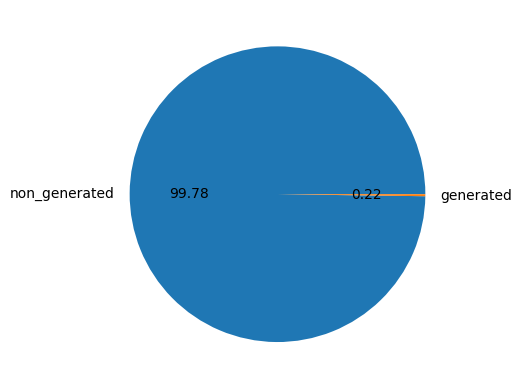

In [126]:
plt.pie(train_essay['generated'].value_counts(),labels = ['non_generated','generated'],autopct="%0.2f")
plt.show()

In [10]:
train_essay.isnull().value_counts()

id     prompt_id  text   generated
False  False      False  False        1378
dtype: int64

In [94]:
train_text = pd.DataFrame(train_essay['text'])
train_generated = pd.DataFrame(train_essay['generated'])

In [95]:
print(train_text.shape,train_generated.shape)

(1378, 1) (1378, 1)


Preprocessing of Data
1. Convert it into embeddings using BERT encoder
2. Oversample that that data using oversampler of scikit-learn

In [96]:
external_data = pd.read_csv('/content/drive/MyDrive/llm-detect-ai-generated-text/daigt_external_dataset.csv')

In [97]:
external_data.head()

,id,text,instructions,source_text
0,6060D28C05B6,Some schools in United States ofter classes fr...,\nTask: Write a persuasive essay on whether or...,\nWhen considering the pros and cons of attend...
1,60623DB5DE7A,"Four-day work week, a remarkable idea to conse...",\nTask: Research the advantages and disadvanta...,\nOne of the primary arguments for implementin...
2,607A39D981DE,Students and their families should consider an...,\nTask: \n\n1. Talk to your parents before tak...,\nBefore making any decisions about getting in...
3,60ACDFA1609E,Agree you will never grow if something beyond ...,\nTask: Write an essay discussing the benefits...,"\nRalph Waldo Emerson once said, ""Go confident..."
4,60AE13D3F07B,I think our character traits are formed by inf...,\nTask: Research and discuss how character tra...,\nHuman character traits are shaped by a wide ...


In [98]:
external_data = external_data.replace(r'\n',' ', regex=True)

In [99]:
external_data.head()

,id,text,instructions,source_text
0,6060D28C05B6,Some schools in United States ofter classes fr...,Task: Write a persuasive essay on whether or ...,When considering the pros and cons of attendi...
1,60623DB5DE7A,"Four-day work week, a remarkable idea to conse...",Task: Research the advantages and disadvantag...,One of the primary arguments for implementing...
2,607A39D981DE,Students and their families should consider an...,Task: 1. Talk to your parents before taking...,Before making any decisions about getting inv...
3,60ACDFA1609E,Agree you will never grow if something beyond ...,Task: Write an essay discussing the benefits ...,"Ralph Waldo Emerson once said, ""Go confidentl..."
4,60AE13D3F07B,I think our character traits are formed by inf...,Task: Research and discuss how character trai...,Human character traits are shaped by a wide r...


In [100]:
external_text = pd.DataFrame(external_data['text'])

In [101]:
external_text.head()

,text
0,Some schools in United States ofter classes fr...
1,"Four-day work week, a remarkable idea to conse..."
2,Students and their families should consider an...
3,Agree you will never grow if something beyond ...
4,I think our character traits are formed by inf...


In [105]:
external_generated = np.zeros([external_text.shape[0]])

In [106]:
for i in range(external_text.shape[0]):
  external_generated[i] = 1

In [107]:
external_generated = pd.DataFrame(external_generated,columns = ['generated'])

In [108]:
external_generated.head()

,generated
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


Dataset Created

In [109]:
df_text = pd.concat([train_text,external_text],axis = 0)
df_generated = pd.concat([train_generated,external_generated],axis = 0)

In [110]:
print(df_text.shape,df_generated.shape)

(3799, 1) (3799, 1)


Balanced Dataset

Enough data Points to train the BERT model

In [86]:
labels = ['non_generated','generated']

In [111]:
df_generated['generated'].value_counts()

1.0    2424
0.0    1375
Name: generated, dtype: int64

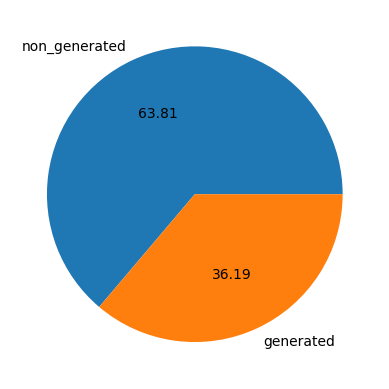

In [112]:
plt.pie(df_generated['generated'].value_counts(),labels = labels,autopct="%0.2f")
plt.show()

In [90]:
import nltk

In [91]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [113]:
df_text['num_charachters'] = df_text['text'].apply(len)
df_text['num_words'] = df_text['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df_text['num_sentences'] = df_text['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

EDA when text is written by student

In [116]:
df_text[df_generated['generated'] == 0][['num_charachters','num_words','num_sentences']].describe()

,num_charachters,num_words,num_sentences
count,1375.000000,1375.000000,1375.000000
mean,3172.581091,622.525091,27.659636
std,918.439217,179.517708,8.715657
min,1486.000000,299.000000,7.000000
25%,2556.500000,498.000000,22.000000
50%,2987.000000,586.000000,27.000000
75%,3624.500000,716.500000,32.000000
max,8436.000000,1515.000000,70.000000


EDA when text is written by AI

In [117]:
df_text[df_generated['generated'] == 1][['num_charachters','num_words','num_sentences']].describe()

,num_charachters,num_words,num_sentences
count,2424.000000,2424.000000,2424.000000
mean,2348.758663,472.834158,18.232261
std,1046.147367,210.972460,10.212360
min,239.000000,52.000000,1.000000
25%,1604.500000,321.750000,11.000000
50%,2180.500000,441.000000,17.000000
75%,2904.500000,582.000000,24.000000
max,6044.000000,1357.000000,90.000000


Let's start working towards model training

In [118]:
X = df_text['text']
y = df_generated['generated']

In [120]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,shuffle = True)

In [121]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2279,) (1520,) (2279,) (1520,)


In [43]:
#oversample = RandomOverSampler(sampling_strategy = 0.5)

Importing BERT APIs from tensorflow

In [122]:
bert_preprocess = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

Function to implement embeddings

In [44]:
#def get_sentence_embeding(sentences):
#    preprocessed_text = bert_preprocess(sentences)
#    return bert_encoder(preprocessed_text)['pooled_output']

Bert Model Implementation

In [123]:
#bert layers
text_input = Input(shape =(),dtype = tf.string)
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#neural network layers
x = Dropout(rate = 0.1)(outputs['pooled_output'])
y = Dense(1,activation = 'sigmoid')(x)

model = Model(inputs = [text_input],outputs = [y])

In [124]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_type_ids': (None,    0         ['input_2[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [125]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name = "accuracy"),
    tf.keras.metrics.Precision(name = "precision"),
    tf.keras.metrics.Recall(name = "recall")
]

model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = METRICS)

In [127]:
model.fit(X_train,y_train,epochs = 5,batch_size = 64)

Epoch 1/5
36/36 [==============================] - 1266s 35s/step - loss: 0.6303 - accuracy: 0.6542 - precision: 0.6580 - recall: 0.9453
Epoch 2/5
36/36 [==============================] - 1255s 35s/step - loss: 0.5122 - accuracy: 0.7683 - precision: 0.7427 - recall: 0.9702
Epoch 3/5
36/36 [==============================] - 1255s 35s/step - loss: 0.4429 - accuracy: 0.8289 - precision: 0.8045 - recall: 0.9640
Epoch 4/5
36/36 [==============================] - 1310s 36s/step - loss: 0.3980 - accuracy: 0.8649 - precision: 0.8497 - recall: 0.9556
Epoch 5/5
36/36 [==============================] - 1313s 36s/step - loss: 0.3673 - accuracy: 0.8723 - precision: 0.8578 - recall: 0.9570
